In [ ]:
# 1. loading the mnist dataset from tensorflow

In [21]:
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data

(trainX, trainy), (testX, testy) =load_data()

print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


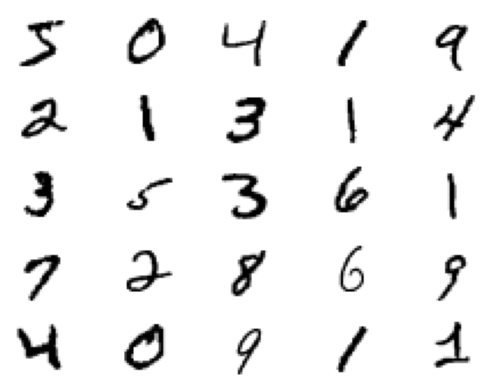

In [27]:
import matplotlib.pyplot as plt

for i in range(25):
    plt.subplot(5,5,1+i)
    plt.axis('off')
    plt.imshow(trainX[i], cmap='gray_r')

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time 
import imageio
import PIL
from tensorflow.keras import layers
import numpy as np
import glob
from IPython import display

In [31]:
from tensorflow.keras.datasets.mnist import load_data

(train_images, train_labels), (_,_) = load_data()

In [38]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

The conversion to (60000, 28, 28, 1) adds an additional dimension, making each image a 3D array with a single channel. This is done to match the expected input shape for convolutional neural networks (CNNs) used in TensorFlow and Keras, which typically expect a 4D input tensor in the shape (batch_size, height, width, channels).

In [39]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [40]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator

In [45]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias = False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256)
    model.add(layers.Conv2DTranspose(128, (5,5), strides = (1,1), padding = 'same', use_bias = False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding='same', use_bias = False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5,5), strides = (2,2), padding = 'same', use_bias = False, activation = 'tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

In [54]:
generator = make_generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)

In [55]:
generated_image.shape

TensorShape([1, 28, 28, 1])

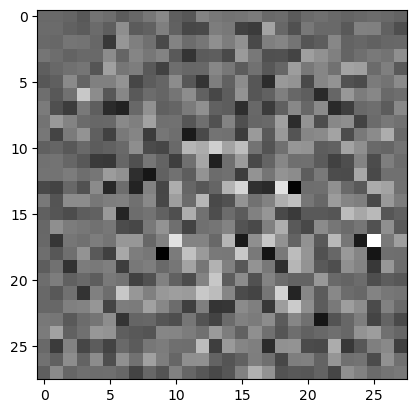

In [56]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Discriminator

In [57]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5,5), strides = (2,2), padding='same', input_shape = [28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides = (2,2), padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1,activation = 'sigmoid'))
    
    return model

In [59]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50015736]], shape=(1, 1), dtype=float32)


## Gen and Disc Loss

In [73]:
# helper function
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [61]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [63]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### gen and disc optimizers

In [64]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [65]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

ValueError: `Checkpoint` was expecting discriminator_optimizer to be a trackable object (an object derived from `Trackable`), got <keras.src.optimizers.adam.Adam object at 0x2c716f5d0>. If you believe this object should be trackable (i.e. it is part of the TensorFlow Python API and manages state), please open an issue.

In [66]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

### train functions

In [70]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [67]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for image_batch in dataset:
            train_step(image_batch)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch+1,
                                seed)
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)

In [68]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## training the model

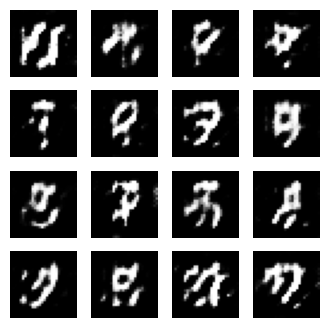

Time for epoch 11 is 173.4272379875183 sec


KeyboardInterrupt: 

In [74]:
train(train_dataset, EPOCHS)

In [75]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [77]:
EPOCHS = 10

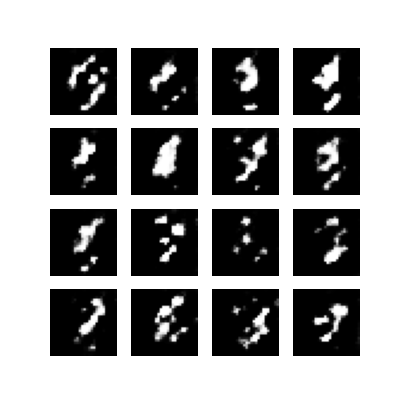

In [78]:
display_image(EPOCHS)

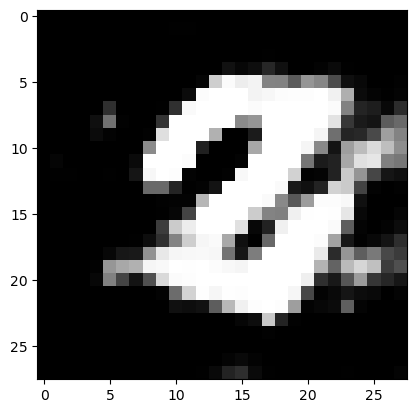

In [90]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training = False)
plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')